Competencia 01 - LGBM - v1

## Importación Librerias y dataset

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import ShuffleSplit, StratifiedShuffleSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer

import lightgbm as lgb

import optuna
from optuna.visualization import plot_optimization_history, plot_param_importances, plot_slice, plot_contour

from time import time

import pickle
import pyarrow.parquet as pq

In [2]:
modelos_path = r'buckets/b1/competencia_0/modelos/' #ver de añadir //
db_path = r'../competencia_01/db//' #ver de añadir / o //
dataset_file = r'../datasets/competencia_01_fe_v1.parquet'

ganancia_acierto = 780000
costo_estimulo = 20000

mes_train =  202102
mes_validacion = 202103
mes_test = 202104

# agregue sus semillas
semillas = [17,19,23,29,31]



In [3]:
# Importo dataset 
data = pd.read_parquet(dataset_file)

In [4]:
# Eliminar columnas
cols_to_drop = [col for col in data.columns if 'lag_2' in col or 'lag_3' in col or 'delta_2' in col or 'numero_de_cliente_' in col or 'foto_mes_' in col]
data = data.drop(columns=cols_to_drop)

In [5]:
data

,numero_de_cliente,foto_mes,active_quarter,cliente_vip,internet,cliente_edad,cliente_antiguedad,mrentabilidad,mrentabilidad_annual,mcomisiones,...,ma_adelanto_w,util_saldo_w,balance_net_w,fee_load_w,fees_per_tx_w,rent_per_tx_w,util_visa_w,util_master_w,share_pago_minimo_w,share_usd_w
0,327515383,202105,1,0,0,63,324,2489.07,35418.65,3560.18,...,0.0,5.705233,3575.94,0.588435,19.038396,13.310535,0.054730,0.0,6826.86,0.009778
1,327515383,202106,1,0,0,63,325,2643.89,35794.76,4637.80,...,0.0,5.422138,5757.74,0.636825,23.783590,13.558410,0.100512,0.0,11706.54,0.009778
2,327532889,202101,1,0,0,86,320,22560.13,43318.83,14981.45,...,0.0,1.091374,7004.14,0.399052,249.690833,376.002167,0.092005,0.0,1395.87,0.009778
3,327532889,202102,1,0,0,86,321,23146.14,62838.61,432.69,...,0.0,0.672431,20051.53,0.018350,7.093279,379.444918,0.050167,0.0,727.26,0.009778
4,327532889,202103,1,0,0,86,322,42832.35,102409.01,8622.66,...,0.0,0.421848,24273.72,0.167573,123.180857,611.890714,0.052913,0.0,1055.70,0.009778
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
978434,327491898,202106,1,0,2,49,286,188.65,7547.73,1684.92,...,0.0,0.206374,1289.95,0.898830,67.396800,7.546000,0.263226,0.0,3917.82,0.009778
978435,327515383,202101,1,0,0,63,320,1050.85,35688.67,2988.24,...,0.0,14.222474,4716.87,0.739647,14.435942,5.076570,0.046798,0.0,5067.36,0.009778
978436,327515383,202102,1,0,0,63,321,1386.40,36831.22,4396.87,...,0.0,13.914004,5035.27,0.760143,18.710085,5.899574,0.069786,0.0,6897.24,0.009778
978437,327515383,202103,1,0,0,63,322,2292.37,36214.16,3983.10,...,0.0,6.471927,4929.12,0.634608,17.168534,9.880905,0.045548,0.0,4598.16,0.009778


## Transformaciones Iniciales

In [6]:
data['clase_peso'] = 1.0

data.loc[data['clase_ternaria'] == 'BAJA+2', 'clase_peso'] = 1.00002
data.loc[data['clase_ternaria'] == 'BAJA+1', 'clase_peso'] = 1.00001 #este es un truco para poder distinguirlos y calcular correctamente la ganancia

In [7]:
data['clase_binaria1'] = 0
data['clase_binaria2'] = 0
data['clase_binaria1'] = np.where(data['clase_ternaria'] == 'BAJA+2', 1, 0)
data['clase_binaria2'] = np.where(data['clase_ternaria'] == 'CONTINUA', 0, 1)

In [8]:
train_data = data[data['foto_mes'] == mes_train] 
val_data = data[data['foto_mes'] == mes_validacion]
test_data = data[data['foto_mes'] == mes_test]

X_train = train_data.drop(['clase_ternaria', 'clase_peso', 'clase_binaria1','clase_binaria2'], axis=1)
y_train_binaria1 = train_data['clase_binaria1']
y_train_binaria2 = train_data['clase_binaria2']
w_train = train_data['clase_peso']

X_val = val_data.drop(['clase_ternaria', 'clase_peso', 'clase_binaria1', 'clase_binaria2'], axis=1)
y_val_binaria1 = val_data['clase_binaria1']  # Mismo target que en train
y_val_binaria2 = val_data['clase_binaria2'] 
w_val = val_data['clase_peso']

X_test = test_data.drop(['clase_ternaria', 'clase_peso', 'clase_binaria1','clase_binaria2'], axis=1)
y_test_binaria1 = test_data['clase_binaria1']
y_test_class = test_data['clase_ternaria']
w_test = test_data['clase_peso']

In [9]:
def lgb_gan_eval(y_pred, data):
    weight = data.get_weight()
    ganancia = np.where(weight == 1.00002, ganancia_acierto, 0) - np.where(weight < 1.00002, costo_estimulo, 0)
    ganancia = ganancia[np.argsort(y_pred)[::-1]]
    ganancia = np.cumsum(ganancia)

    return 'gan_eval', np.max(ganancia) , True

## Optuna

In [11]:
#mio
def objective(trial):

    num_leaves = trial.suggest_int('num_leaves', 50, 500)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.5) # mas bajo, más iteraciones necesita
    min_data_in_leaf = trial.suggest_int('min_data_in_leaf', 5, 3000)
    feature_fraction = trial.suggest_float('feature_fraction', 0.3, 1.0)
    bagging_fraction = trial.suggest_float('bagging_fraction', 0.1, 0.8)
    min_gain_to_split = trial.suggest_float('min_gain_to_split', 0.0, 0.4) #corta splits debiles

    params = {
        'objective': 'binary',
        'metric': 'custom',
        'boosting_type': 'gbdt',
        'first_metric_only': True,
        'boost_from_average': True,
        'feature_pre_filter': False,
        'max_bin': 127,
        'num_leaves': num_leaves,
        'learning_rate': learning_rate,
        'min_data_in_leaf': min_data_in_leaf,
        'feature_fraction': feature_fraction,
        'bagging_fraction': bagging_fraction,
        'min_gain_to_split': min_gain_to_split,
        'seed': semillas[0],
        'verbose': -1
    }
    train_dataset = lgb.Dataset(X_train,
                              label=y_train_binaria2, # eligir la clase
                              weight=w_train)
    val_dataset = lgb.Dataset(X_val,
                              label=y_val_binaria2,
                              weight=w_val,
                              reference=train_dataset)

    # Para almacenar los resultados de evaluación
    evals_result = {}

    # Crear el callback para guardar resultados
    record_eval = lgb.record_evaluation(evals_result)

    # Entrenar modelo
    model = lgb.train(
        params,
        train_dataset,
        valid_sets=[val_dataset],
        num_boost_round=15000, #
       callbacks=[
            lgb.early_stopping(stopping_rounds=int(50 + 5 / learning_rate)),
            record_eval],
        feval=lgb_gan_eval,
    )

    # Acceder a los resultados de validación 
    val_gan_history = evals_result['valid_0']['gan_eval']
    max_gan = max(val_gan_history)
    best_iter = val_gan_history.index(max_gan) + 1

    # Guardamos cual es la mejor iteración del modelo
    trial.set_user_attr("best_iter", best_iter)

    return max_gan * 5


storage_name = "sqlite:///" + "../competencia_01/db/dboptimization_lgbm_competencia__gcp_01.db"
study_name = "lgbm_gcp_binaria2_v3"

study = optuna.create_study(
    direction="maximize",
    study_name=study_name,
    storage=storage_name,
    load_if_exists=True,
)


[I 2025-10-08 22:52:39,412] Using an existing study with name 'lgbm_gcp_binaria2_v3' instead of creating a new one.


In [12]:
study.optimize(objective, n_trials=85) 

Training until validation scores don't improve for 99 rounds
Early stopping, best iteration is:
[18]	valid_0's gan_eval: 2.7082e+08


[I 2025-10-08 05:45:37,465] Trial 2 finished with value: 1354100000.0 and parameters: {'num_leaves': 485, 'learning_rate': 0.1014984129564033, 'min_data_in_leaf': 890, 'feature_fraction': 0.47188659783916254, 'bagging_fraction': 0.4114434068072734, 'min_gain_to_split': 0.27818572107118644}. Best is trial 2 with value: 1354100000.0.


Training until validation scores don't improve for 66 rounds
Early stopping, best iteration is:
[1]	valid_0's gan_eval: 2.0228e+08


[I 2025-10-08 05:47:40,472] Trial 3 finished with value: 1011400000.0 and parameters: {'num_leaves': 497, 'learning_rate': 0.30861456430361894, 'min_data_in_leaf': 210, 'feature_fraction': 0.6309524181488579, 'bagging_fraction': 0.7794649891745292, 'min_gain_to_split': 0.35147217168235545}. Best is trial 2 with value: 1354100000.0.


Training until validation scores don't improve for 63 rounds
Early stopping, best iteration is:
[8]	valid_0's gan_eval: 2.027e+08


[I 2025-10-08 05:49:37,315] Trial 4 finished with value: 1013500000.0 and parameters: {'num_leaves': 345, 'learning_rate': 0.3787918142707457, 'min_data_in_leaf': 1562, 'feature_fraction': 0.9707318000920147, 'bagging_fraction': 0.2729253532056388, 'min_gain_to_split': 0.39765387942523717}. Best is trial 2 with value: 1354100000.0.


Training until validation scores don't improve for 126 rounds
Early stopping, best iteration is:
[37]	valid_0's gan_eval: 2.7776e+08


[I 2025-10-08 05:52:20,620] Trial 5 finished with value: 1388800000.0 and parameters: {'num_leaves': 386, 'learning_rate': 0.06559004745547559, 'min_data_in_leaf': 1199, 'feature_fraction': 0.444926664904013, 'bagging_fraction': 0.710305198481836, 'min_gain_to_split': 0.3010005718832214}. Best is trial 5 with value: 1388800000.0.


Training until validation scores don't improve for 80 rounds
Early stopping, best iteration is:
[14]	valid_0's gan_eval: 2.2372e+08


[I 2025-10-08 05:54:34,766] Trial 6 finished with value: 1118600000.0 and parameters: {'num_leaves': 85, 'learning_rate': 0.16273964853698128, 'min_data_in_leaf': 561, 'feature_fraction': 0.5300781382026489, 'bagging_fraction': 0.6910692215672656, 'min_gain_to_split': 0.08420703375770754}. Best is trial 5 with value: 1388800000.0.


Training until validation scores don't improve for 78 rounds
Early stopping, best iteration is:
[7]	valid_0's gan_eval: 2.3128e+08


[I 2025-10-08 05:56:38,607] Trial 7 finished with value: 1156400000.0 and parameters: {'num_leaves': 52, 'learning_rate': 0.17551027325286275, 'min_data_in_leaf': 595, 'feature_fraction': 0.9358911775529966, 'bagging_fraction': 0.11081544950303848, 'min_gain_to_split': 0.2491891964503061}. Best is trial 5 with value: 1388800000.0.


Training until validation scores don't improve for 69 rounds
Early stopping, best iteration is:
[20]	valid_0's gan_eval: 2.3284e+08


[I 2025-10-08 05:58:38,176] Trial 8 finished with value: 1164200000.0 and parameters: {'num_leaves': 481, 'learning_rate': 0.2617188056952719, 'min_data_in_leaf': 2192, 'feature_fraction': 0.924150736146049, 'bagging_fraction': 0.7603255428956698, 'min_gain_to_split': 0.2765516206850319}. Best is trial 5 with value: 1388800000.0.


Training until validation scores don't improve for 68 rounds
Early stopping, best iteration is:
[12]	valid_0's gan_eval: 2.2402e+08


[I 2025-10-08 06:00:33,174] Trial 9 finished with value: 1120100000.0 and parameters: {'num_leaves': 381, 'learning_rate': 0.2651932375743276, 'min_data_in_leaf': 2037, 'feature_fraction': 0.8656693387499708, 'bagging_fraction': 0.1205941046176147, 'min_gain_to_split': 0.38395603527484595}. Best is trial 5 with value: 1388800000.0.


Training until validation scores don't improve for 192 rounds
Early stopping, best iteration is:
[110]	valid_0's gan_eval: 2.7372e+08


[I 2025-10-08 06:03:48,757] Trial 10 finished with value: 1368600000.0 and parameters: {'num_leaves': 230, 'learning_rate': 0.035134201403063434, 'min_data_in_leaf': 2994, 'feature_fraction': 0.31722017098022337, 'bagging_fraction': 0.5375889391578523, 'min_gain_to_split': 0.14306940890067918}. Best is trial 5 with value: 1388800000.0.


Training until validation scores don't improve for 251 rounds
Early stopping, best iteration is:
[186]	valid_0's gan_eval: 2.8034e+08


[I 2025-10-08 06:06:32,551] Trial 11 finished with value: 1401700000.0 and parameters: {'num_leaves': 214, 'learning_rate': 0.024788937110902493, 'min_data_in_leaf': 2995, 'feature_fraction': 0.3070713732958805, 'bagging_fraction': 0.5590210288966938, 'min_gain_to_split': 0.15038530371521577}. Best is trial 11 with value: 1401700000.0.


Training until validation scores don't improve for 270 rounds
Early stopping, best iteration is:
[152]	valid_0's gan_eval: 2.8174e+08


[I 2025-10-08 06:09:06,609] Trial 12 finished with value: 1408700000.0 and parameters: {'num_leaves': 225, 'learning_rate': 0.02269695193601839, 'min_data_in_leaf': 2777, 'feature_fraction': 0.30052076895664154, 'bagging_fraction': 0.5377249562525823, 'min_gain_to_split': 0.17861210535791727}. Best is trial 12 with value: 1408700000.0.


Training until validation scores don't improve for 397 rounds
Early stopping, best iteration is:
[282]	valid_0's gan_eval: 2.7792e+08


[I 2025-10-08 06:14:18,488] Trial 13 finished with value: 1389600000.0 and parameters: {'num_leaves': 208, 'learning_rate': 0.014385973567510656, 'min_data_in_leaf': 2984, 'feature_fraction': 0.31421348351805045, 'bagging_fraction': 0.48163760099888425, 'min_gain_to_split': 0.18185858939431976}. Best is trial 12 with value: 1408700000.0.


Training until validation scores don't improve for 74 rounds
Early stopping, best iteration is:
[20]	valid_0's gan_eval: 2.4752e+08


[I 2025-10-08 06:16:08,433] Trial 14 finished with value: 1237600000.0 and parameters: {'num_leaves': 178, 'learning_rate': 0.20403788968637976, 'min_data_in_leaf': 2456, 'feature_fraction': 0.3767814452517606, 'bagging_fraction': 0.5931256536464379, 'min_gain_to_split': 0.13635820113182193}. Best is trial 12 with value: 1408700000.0.


Training until validation scores don't improve for 110 rounds
Early stopping, best iteration is:
[49]	valid_0's gan_eval: 2.641e+08


[I 2025-10-08 06:18:12,854] Trial 15 finished with value: 1320500000.0 and parameters: {'num_leaves': 264, 'learning_rate': 0.08276384345991736, 'min_data_in_leaf': 2551, 'feature_fraction': 0.608996578286702, 'bagging_fraction': 0.382549879924511, 'min_gain_to_split': 0.1896642874467701}. Best is trial 12 with value: 1408700000.0.


Training until validation scores don't improve for 536 rounds
Early stopping, best iteration is:
[296]	valid_0's gan_eval: 2.7214e+08


[I 2025-10-08 06:23:06,886] Trial 16 finished with value: 1360700000.0 and parameters: {'num_leaves': 307, 'learning_rate': 0.010271128610071316, 'min_data_in_leaf': 2592, 'feature_fraction': 0.7495843320149749, 'bagging_fraction': 0.5138340983509635, 'min_gain_to_split': 0.09328818165498695}. Best is trial 12 with value: 1408700000.0.


Training until validation scores don't improve for 97 rounds
Early stopping, best iteration is:
[37]	valid_0's gan_eval: 2.651e+08


[I 2025-10-08 06:25:16,878] Trial 17 finished with value: 1325500000.0 and parameters: {'num_leaves': 162, 'learning_rate': 0.10553046639385873, 'min_data_in_leaf': 1944, 'feature_fraction': 0.5133264181237132, 'bagging_fraction': 0.3303303932554468, 'min_gain_to_split': 0.2317025124144103}. Best is trial 12 with value: 1408700000.0.


Training until validation scores don't improve for 63 rounds
Early stopping, best iteration is:
[9]	valid_0's gan_eval: 2.2378e+08


[I 2025-10-08 06:27:03,965] Trial 18 finished with value: 1118900000.0 and parameters: {'num_leaves': 262, 'learning_rate': 0.3846124940628954, 'min_data_in_leaf': 2814, 'feature_fraction': 0.3748324074450913, 'bagging_fraction': 0.5871337036332347, 'min_gain_to_split': 0.017355262109723324}. Best is trial 12 with value: 1408700000.0.


Training until validation scores don't improve for 73 rounds
Early stopping, best iteration is:
[19]	valid_0's gan_eval: 2.3722e+08


[I 2025-10-08 06:28:59,041] Trial 19 finished with value: 1186100000.0 and parameters: {'num_leaves': 308, 'learning_rate': 0.2122465535546661, 'min_data_in_leaf': 2226, 'feature_fraction': 0.570847635401343, 'bagging_fraction': 0.44892043034285495, 'min_gain_to_split': 0.1459968902881866}. Best is trial 12 with value: 1408700000.0.


Training until validation scores don't improve for 134 rounds
Early stopping, best iteration is:
[82]	valid_0's gan_eval: 2.6644e+08


[I 2025-10-08 06:31:32,497] Trial 20 finished with value: 1332200000.0 and parameters: {'num_leaves': 164, 'learning_rate': 0.05948985532699295, 'min_data_in_leaf': 1827, 'feature_fraction': 0.7198921017749488, 'bagging_fraction': 0.6088086949443308, 'min_gain_to_split': 0.0769476811304501}. Best is trial 12 with value: 1408700000.0.


Training until validation scores don't improve for 327 rounds
Early stopping, best iteration is:
[189]	valid_0's gan_eval: 2.802e+08


[I 2025-10-08 06:34:15,138] Trial 21 finished with value: 1401000000.0 and parameters: {'num_leaves': 212, 'learning_rate': 0.018040673960932008, 'min_data_in_leaf': 2988, 'feature_fraction': 0.3027188145152928, 'bagging_fraction': 0.5003847863067135, 'min_gain_to_split': 0.19509088538118236}. Best is trial 12 with value: 1408700000.0.


Training until validation scores don't improve for 89 rounds
Early stopping, best iteration is:
[32]	valid_0's gan_eval: 2.7656e+08


[I 2025-10-08 06:36:04,839] Trial 22 finished with value: 1382800000.0 and parameters: {'num_leaves': 222, 'learning_rate': 0.12507053052470307, 'min_data_in_leaf': 2769, 'feature_fraction': 0.30341103430072514, 'bagging_fraction': 0.520725946681935, 'min_gain_to_split': 0.2236472287203296}. Best is trial 12 with value: 1408700000.0.


Training until validation scores don't improve for 148 rounds
Early stopping, best iteration is:
[125]	valid_0's gan_eval: 2.7226e+08


[I 2025-10-08 06:38:26,147] Trial 23 finished with value: 1361300000.0 and parameters: {'num_leaves': 189, 'learning_rate': 0.05073723670567473, 'min_data_in_leaf': 2401, 'feature_fraction': 0.3811199963498223, 'bagging_fraction': 0.4208737515692428, 'min_gain_to_split': 0.16891809921985557}. Best is trial 12 with value: 1408700000.0.


Training until validation scores don't improve for 122 rounds
Early stopping, best iteration is:
[39]	valid_0's gan_eval: 2.7026e+08


[I 2025-10-08 06:40:29,442] Trial 24 finished with value: 1351300000.0 and parameters: {'num_leaves': 237, 'learning_rate': 0.0688566756290799, 'min_data_in_leaf': 2731, 'feature_fraction': 0.3874203899816051, 'bagging_fraction': 0.5475572245608252, 'min_gain_to_split': 0.12049477060909862}. Best is trial 12 with value: 1408700000.0.


Training until validation scores don't improve for 236 rounds
Early stopping, best iteration is:
[142]	valid_0's gan_eval: 2.7652e+08


[I 2025-10-08 06:42:53,327] Trial 25 finished with value: 1382600000.0 and parameters: {'num_leaves': 133, 'learning_rate': 0.026827686811821183, 'min_data_in_leaf': 2970, 'feature_fraction': 0.30020262002266684, 'bagging_fraction': 0.6648196042137271, 'min_gain_to_split': 0.21375894431577536}. Best is trial 12 with value: 1408700000.0.


Training until validation scores don't improve for 84 rounds
Early stopping, best iteration is:
[18]	valid_0's gan_eval: 2.5752e+08


[I 2025-10-08 06:44:50,201] Trial 26 finished with value: 1287600000.0 and parameters: {'num_leaves': 288, 'learning_rate': 0.14660800982676753, 'min_data_in_leaf': 2344, 'feature_fraction': 0.362730041625349, 'bagging_fraction': 0.31057089218955986, 'min_gain_to_split': 0.1740988943947904}. Best is trial 12 with value: 1408700000.0.


Training until validation scores don't improve for 101 rounds
Early stopping, best iteration is:
[34]	valid_0's gan_eval: 2.7002e+08


[I 2025-10-08 06:46:53,467] Trial 27 finished with value: 1350100000.0 and parameters: {'num_leaves': 133, 'learning_rate': 0.09684951120890782, 'min_data_in_leaf': 2683, 'feature_fraction': 0.4457650620900358, 'bagging_fraction': 0.48249868811917496, 'min_gain_to_split': 0.11326452312618777}. Best is trial 12 with value: 1408700000.0.


Training until validation scores don't improve for 60 rounds
Early stopping, best iteration is:
[5]	valid_0's gan_eval: 2.0518e+08


[I 2025-10-08 06:48:47,065] Trial 28 finished with value: 1025900000.0 and parameters: {'num_leaves': 335, 'learning_rate': 0.4862429722189914, 'min_data_in_leaf': 1741, 'feature_fraction': 0.4933596064903928, 'bagging_fraction': 0.5825398665722074, 'min_gain_to_split': 0.041560786563191926}. Best is trial 12 with value: 1408700000.0.


Training until validation scores don't improve for 64 rounds
Early stopping, best iteration is:
[10]	valid_0's gan_eval: 2.239e+08


[I 2025-10-08 06:50:40,682] Trial 29 finished with value: 1119500000.0 and parameters: {'num_leaves': 254, 'learning_rate': 0.3488938140895832, 'min_data_in_leaf': 2818, 'feature_fraction': 0.6985714937047002, 'bagging_fraction': 0.6301332461869674, 'min_gain_to_split': 0.24357678350166284}. Best is trial 12 with value: 1408700000.0.


Training until validation scores don't improve for 60 rounds
Early stopping, best iteration is:
[9]	valid_0's gan_eval: 2.1292e+08


[I 2025-10-08 06:52:26,175] Trial 30 finished with value: 1064600000.0 and parameters: {'num_leaves': 197, 'learning_rate': 0.4548731590855297, 'min_data_in_leaf': 2547, 'feature_fraction': 0.41989989632856584, 'bagging_fraction': 0.47402588164117315, 'min_gain_to_split': 0.16068611762396334}. Best is trial 12 with value: 1408700000.0.


Training until validation scores don't improve for 348 rounds
Early stopping, best iteration is:
[200]	valid_0's gan_eval: 2.7852e+08


[I 2025-10-08 06:55:18,910] Trial 31 finished with value: 1392600000.0 and parameters: {'num_leaves': 207, 'learning_rate': 0.016728304397174557, 'min_data_in_leaf': 2874, 'feature_fraction': 0.33283731422163637, 'bagging_fraction': 0.49071934693528835, 'min_gain_to_split': 0.19354083075482698}. Best is trial 12 with value: 1408700000.0.


Training until validation scores don't improve for 154 rounds
Early stopping, best iteration is:
[71]	valid_0's gan_eval: 2.7012e+08


[I 2025-10-08 06:57:28,924] Trial 32 finished with value: 1350600000.0 and parameters: {'num_leaves': 151, 'learning_rate': 0.04805313113692169, 'min_data_in_leaf': 2998, 'feature_fraction': 0.34437582470922823, 'bagging_fraction': 0.40361253944278835, 'min_gain_to_split': 0.20097267695310894}. Best is trial 12 with value: 1408700000.0.


Training until validation scores don't improve for 195 rounds
Early stopping, best iteration is:
[119]	valid_0's gan_eval: 2.811e+08


[I 2025-10-08 06:59:53,512] Trial 33 finished with value: 1405500000.0 and parameters: {'num_leaves': 106, 'learning_rate': 0.03429186805155546, 'min_data_in_leaf': 2795, 'feature_fraction': 0.4028731235112192, 'bagging_fraction': 0.36343930886248027, 'min_gain_to_split': 0.19836142057076186}. Best is trial 12 with value: 1408700000.0.


Training until validation scores don't improve for 91 rounds
Early stopping, best iteration is:
[48]	valid_0's gan_eval: 2.7072e+08


[I 2025-10-08 07:01:59,639] Trial 34 finished with value: 1353600000.0 and parameters: {'num_leaves': 99, 'learning_rate': 0.12066324888835625, 'min_data_in_leaf': 2211, 'feature_fraction': 0.42026554873713806, 'bagging_fraction': 0.3618670876454809, 'min_gain_to_split': 0.25565123957573976}. Best is trial 12 with value: 1408700000.0.


Training until validation scores don't improve for 109 rounds
Early stopping, best iteration is:
[42]	valid_0's gan_eval: 2.6616e+08


[I 2025-10-08 07:04:12,290] Trial 35 finished with value: 1330800000.0 and parameters: {'num_leaves': 107, 'learning_rate': 0.08451629607066032, 'min_data_in_leaf': 2639, 'feature_fraction': 0.40676119838286273, 'bagging_fraction': 0.2417126559876374, 'min_gain_to_split': 0.049275747131451164}. Best is trial 12 with value: 1408700000.0.


Training until validation scores don't improve for 181 rounds
Early stopping, best iteration is:
[86]	valid_0's gan_eval: 2.7798e+08


[I 2025-10-08 07:06:41,073] Trial 36 finished with value: 1389900000.0 and parameters: {'num_leaves': 61, 'learning_rate': 0.03806053779738154, 'min_data_in_leaf': 1102, 'feature_fraction': 0.47050738025504957, 'bagging_fraction': 0.45462213294573167, 'min_gain_to_split': 0.3020526123806233}. Best is trial 12 with value: 1408700000.0.


Training until validation scores don't improve for 119 rounds
Early stopping, best iteration is:
[60]	valid_0's gan_eval: 2.611e+08


[I 2025-10-08 07:09:19,047] Trial 37 finished with value: 1305500000.0 and parameters: {'num_leaves': 289, 'learning_rate': 0.0721816004906399, 'min_data_in_leaf': 1395, 'feature_fraction': 0.8289426757647524, 'bagging_fraction': 0.1948373310927637, 'min_gain_to_split': 0.32589855700267734}. Best is trial 12 with value: 1408700000.0.


Training until validation scores don't improve for 77 rounds
Early stopping, best iteration is:
[2]	valid_0's gan_eval: 2.183e+08


[I 2025-10-08 07:11:19,803] Trial 38 finished with value: 1091500000.0 and parameters: {'num_leaves': 76, 'learning_rate': 0.17977560827833602, 'min_data_in_leaf': 184, 'feature_fraction': 0.34336298955358086, 'bagging_fraction': 0.5680199575058821, 'min_gain_to_split': 0.2105815118034698}. Best is trial 12 with value: 1408700000.0.


Training until validation scores don't improve for 94 rounds
Early stopping, best iteration is:
[25]	valid_0's gan_eval: 2.587e+08


[I 2025-10-08 07:13:39,924] Trial 39 finished with value: 1293500000.0 and parameters: {'num_leaves': 125, 'learning_rate': 0.11206549478031419, 'min_data_in_leaf': 2385, 'feature_fraction': 0.5729524880016006, 'bagging_fraction': 0.6548136447720586, 'min_gain_to_split': 0.12001965424315837}. Best is trial 12 with value: 1408700000.0.


Training until validation scores don't improve for 161 rounds
Early stopping, best iteration is:
[87]	valid_0's gan_eval: 2.7562e+08


[I 2025-10-08 07:16:05,157] Trial 40 finished with value: 1378100000.0 and parameters: {'num_leaves': 242, 'learning_rate': 0.04496966675575957, 'min_data_in_leaf': 2810, 'feature_fraction': 0.4523308293008084, 'bagging_fraction': 0.7327728179824351, 'min_gain_to_split': 0.27795563837482606}. Best is trial 12 with value: 1408700000.0.


Training until validation scores don't improve for 469 rounds
Early stopping, best iteration is:
[270]	valid_0's gan_eval: 2.7434e+08


[I 2025-10-08 07:19:41,898] Trial 41 finished with value: 1371700000.0 and parameters: {'num_leaves': 216, 'learning_rate': 0.011918614452953665, 'min_data_in_leaf': 2864, 'feature_fraction': 0.34001863390860115, 'bagging_fraction': 0.5076670305316773, 'min_gain_to_split': 0.19754581225858858}. Best is trial 12 with value: 1408700000.0.


Training until validation scores don't improve for 225 rounds
Early stopping, best iteration is:
[160]	valid_0's gan_eval: 2.7874e+08


[I 2025-10-08 07:22:17,765] Trial 42 finished with value: 1393700000.0 and parameters: {'num_leaves': 183, 'learning_rate': 0.02844374569254461, 'min_data_in_leaf': 2659, 'feature_fraction': 0.3373008165125156, 'bagging_fraction': 0.44420892484604635, 'min_gain_to_split': 0.15487350042875625}. Best is trial 12 with value: 1408700000.0.


Training until validation scores don't improve for 132 rounds
Early stopping, best iteration is:
[64]	valid_0's gan_eval: 2.6994e+08


[I 2025-10-08 07:24:39,812] Trial 43 finished with value: 1349700000.0 and parameters: {'num_leaves': 179, 'learning_rate': 0.060878248495099326, 'min_data_in_leaf': 2649, 'feature_fraction': 0.3985726571330873, 'bagging_fraction': 0.4249295098945247, 'min_gain_to_split': 0.16408584999536602}. Best is trial 12 with value: 1408700000.0.


Training until validation scores don't improve for 107 rounds
Early stopping, best iteration is:
[61]	valid_0's gan_eval: 2.628e+08


[I 2025-10-08 07:26:45,048] Trial 44 finished with value: 1314000000.0 and parameters: {'num_leaves': 153, 'learning_rate': 0.08690790352317297, 'min_data_in_leaf': 2467, 'feature_fraction': 0.351872924202605, 'bagging_fraction': 0.35021961071937535, 'min_gain_to_split': 0.1485004266571224}. Best is trial 12 with value: 1408700000.0.


Training until validation scores don't improve for 84 rounds
Early stopping, best iteration is:
[17]	valid_0's gan_eval: 2.447e+08


[I 2025-10-08 07:28:48,040] Trial 45 finished with value: 1223500000.0 and parameters: {'num_leaves': 466, 'learning_rate': 0.14444844807477944, 'min_data_in_leaf': 412, 'feature_fraction': 0.3036790518236759, 'bagging_fraction': 0.3039010820585095, 'min_gain_to_split': 0.0975397171029457}. Best is trial 12 with value: 1408700000.0.


Training until validation scores don't improve for 194 rounds
Early stopping, best iteration is:
[104]	valid_0's gan_eval: 2.758e+08


[I 2025-10-08 07:31:19,095] Trial 46 finished with value: 1379000000.0 and parameters: {'num_leaves': 189, 'learning_rate': 0.03467516684678733, 'min_data_in_leaf': 2289, 'feature_fraction': 0.3630861127287749, 'bagging_fraction': 0.44801252315967605, 'min_gain_to_split': 0.13029673396043318}. Best is trial 12 with value: 1408700000.0.


Training until validation scores don't improve for 67 rounds
Early stopping, best iteration is:
[12]	valid_0's gan_eval: 2.3186e+08


[I 2025-10-08 07:33:19,829] Trial 47 finished with value: 1159300000.0 and parameters: {'num_leaves': 242, 'learning_rate': 0.2916224940368333, 'min_data_in_leaf': 2062, 'feature_fraction': 0.33425830566328985, 'bagging_fraction': 0.5541728661908014, 'min_gain_to_split': 0.1843975070735566}. Best is trial 12 with value: 1408700000.0.


Training until validation scores don't improve for 207 rounds
Early stopping, best iteration is:
[108]	valid_0's gan_eval: 2.7554e+08


[I 2025-10-08 07:35:54,901] Trial 48 finished with value: 1377700000.0 and parameters: {'num_leaves': 274, 'learning_rate': 0.03174098504669813, 'min_data_in_leaf': 2504, 'feature_fraction': 0.4298427149987275, 'bagging_fraction': 0.37177871249971106, 'min_gain_to_split': 0.15434411388710587}. Best is trial 12 with value: 1408700000.0.


Training until validation scores don't improve for 72 rounds
Early stopping, best iteration is:
[1]	valid_0's gan_eval: 1.8296e+08


[I 2025-10-08 07:37:41,994] Trial 49 finished with value: 914800000.0 and parameters: {'num_leaves': 173, 'learning_rate': 0.21860325120847324, 'min_data_in_leaf': 20, 'feature_fraction': 0.5442244703023162, 'bagging_fraction': 0.6247450410736388, 'min_gain_to_split': 0.2364242853169931}. Best is trial 12 with value: 1408700000.0.


Training until validation scores don't improve for 125 rounds
Early stopping, best iteration is:
[77]	valid_0's gan_eval: 2.6612e+08


[I 2025-10-08 07:39:56,975] Trial 50 finished with value: 1330600000.0 and parameters: {'num_leaves': 211, 'learning_rate': 0.06594448678947865, 'min_data_in_leaf': 2912, 'feature_fraction': 0.6571215278173136, 'bagging_fraction': 0.5403929319373634, 'min_gain_to_split': 0.26060507540089123}. Best is trial 12 with value: 1408700000.0.


Training until validation scores don't improve for 472 rounds
Early stopping, best iteration is:
[419]	valid_0's gan_eval: 2.7798e+08


[I 2025-10-08 07:43:51,287] Trial 51 finished with value: 1389900000.0 and parameters: {'num_leaves': 198, 'learning_rate': 0.011836503519930413, 'min_data_in_leaf': 2715, 'feature_fraction': 0.3321284091702986, 'bagging_fraction': 0.5019839463591436, 'min_gain_to_split': 0.18786288613637606}. Best is trial 12 with value: 1408700000.0.


Training until validation scores don't improve for 229 rounds
Early stopping, best iteration is:
[127]	valid_0's gan_eval: 2.7824e+08


[I 2025-10-08 07:46:25,658] Trial 52 finished with value: 1391200000.0 and parameters: {'num_leaves': 230, 'learning_rate': 0.027859255192990075, 'min_data_in_leaf': 2881, 'feature_fraction': 0.3229576501932323, 'bagging_fraction': 0.40320185754816473, 'min_gain_to_split': 0.21800735576275548}. Best is trial 12 with value: 1408700000.0.


Training until validation scores don't improve for 506 rounds
Early stopping, best iteration is:
[335]	valid_0's gan_eval: 2.7918e+08


[I 2025-10-08 07:50:16,223] Trial 53 finished with value: 1395900000.0 and parameters: {'num_leaves': 110, 'learning_rate': 0.010949535390970093, 'min_data_in_leaf': 2604, 'feature_fraction': 0.39280061102422914, 'bagging_fraction': 0.44535309753330643, 'min_gain_to_split': 0.1731351411785197}. Best is trial 12 with value: 1408700000.0.


Training until validation scores don't improve for 150 rounds
Early stopping, best iteration is:
[77]	valid_0's gan_eval: 2.7246e+08


[I 2025-10-08 07:52:38,020] Trial 54 finished with value: 1362300000.0 and parameters: {'num_leaves': 117, 'learning_rate': 0.04955736019673228, 'min_data_in_leaf': 2582, 'feature_fraction': 0.39101242186898777, 'bagging_fraction': 0.44150575500454897, 'min_gain_to_split': 0.1743674149959339}. Best is trial 12 with value: 1408700000.0.


Training until validation scores don't improve for 105 rounds
Early stopping, best iteration is:
[44]	valid_0's gan_eval: 2.6836e+08


[I 2025-10-08 07:54:58,846] Trial 55 finished with value: 1341800000.0 and parameters: {'num_leaves': 84, 'learning_rate': 0.09014877503096558, 'min_data_in_leaf': 2100, 'feature_fraction': 0.4665732337475025, 'bagging_fraction': 0.390455312372384, 'min_gain_to_split': 0.13821753511838575}. Best is trial 12 with value: 1408700000.0.


Training until validation scores don't improve for 119 rounds
Early stopping, best iteration is:
[41]	valid_0's gan_eval: 2.735e+08


[I 2025-10-08 07:57:12,438] Trial 56 finished with value: 1367500000.0 and parameters: {'num_leaves': 145, 'learning_rate': 0.07175835363691879, 'min_data_in_leaf': 2703, 'feature_fraction': 0.36360864926993147, 'bagging_fraction': 0.5220791362784616, 'min_gain_to_split': 0.0695189360150329}. Best is trial 12 with value: 1408700000.0.


Training until validation scores don't improve for 225 rounds
Early stopping, best iteration is:
[90]	valid_0's gan_eval: 2.8662e+08


[I 2025-10-08 08:00:30,988] Trial 57 finished with value: 1433100000.0 and parameters: {'num_leaves': 116, 'learning_rate': 0.028444080580463386, 'min_data_in_leaf': 823, 'feature_fraction': 0.5043428020071472, 'bagging_fraction': 0.46862119337306046, 'min_gain_to_split': 0.10676380264118199}. Best is trial 57 with value: 1433100000.0.


Training until validation scores don't improve for 98 rounds
Early stopping, best iteration is:
[10]	valid_0's gan_eval: 2.696e+08


[I 2025-10-08 08:02:47,061] Trial 58 finished with value: 1348000000.0 and parameters: {'num_leaves': 64, 'learning_rate': 0.10294660413714288, 'min_data_in_leaf': 597, 'feature_fraction': 0.49309684750622224, 'bagging_fraction': 0.46910200535543334, 'min_gain_to_split': 0.09897235781203241}. Best is trial 57 with value: 1433100000.0.


Training until validation scores don't improve for 153 rounds
Early stopping, best iteration is:
[34]	valid_0's gan_eval: 2.7424e+08


[I 2025-10-08 08:05:38,479] Trial 59 finished with value: 1371200000.0 and parameters: {'num_leaves': 102, 'learning_rate': 0.04845792608787844, 'min_data_in_leaf': 849, 'feature_fraction': 0.4005640041603889, 'bagging_fraction': 0.33107783006112496, 'min_gain_to_split': 0.10618981749977767}. Best is trial 57 with value: 1433100000.0.


Training until validation scores don't improve for 537 rounds
Early stopping, best iteration is:
[286]	valid_0's gan_eval: 2.786e+08


[I 2025-10-08 08:11:03,368] Trial 60 finished with value: 1393000000.0 and parameters: {'num_leaves': 392, 'learning_rate': 0.010246893851853895, 'min_data_in_leaf': 1505, 'feature_fraction': 0.5317170397756907, 'bagging_fraction': 0.5663633183009417, 'min_gain_to_split': 0.13173913305525317}. Best is trial 57 with value: 1433100000.0.


Training until validation scores don't improve for 235 rounds
Early stopping, best iteration is:
[133]	valid_0's gan_eval: 2.8006e+08


[I 2025-10-08 08:13:45,681] Trial 61 finished with value: 1400300000.0 and parameters: {'num_leaves': 119, 'learning_rate': 0.02693141223199552, 'min_data_in_leaf': 1195, 'feature_fraction': 0.3067905003306335, 'bagging_fraction': 0.42293395946346524, 'min_gain_to_split': 0.2055270844003876}. Best is trial 57 with value: 1433100000.0.


Training until validation scores don't improve for 136 rounds
Early stopping, best iteration is:
[36]	valid_0's gan_eval: 2.7776e+08


[I 2025-10-08 08:15:58,705] Trial 62 finished with value: 1388800000.0 and parameters: {'num_leaves': 115, 'learning_rate': 0.05764646724265976, 'min_data_in_leaf': 955, 'feature_fraction': 0.30824663666773655, 'bagging_fraction': 0.6006035889337704, 'min_gain_to_split': 0.2083022245466179}. Best is trial 57 with value: 1433100000.0.


Training until validation scores don't improve for 204 rounds
Early stopping, best iteration is:
[66]	valid_0's gan_eval: 2.757e+08


[I 2025-10-08 08:18:48,000] Trial 63 finished with value: 1378500000.0 and parameters: {'num_leaves': 142, 'learning_rate': 0.032463033074120635, 'min_data_in_leaf': 741, 'feature_fraction': 0.3695071378887905, 'bagging_fraction': 0.5293633406420102, 'min_gain_to_split': 0.23195371614093654}. Best is trial 57 with value: 1433100000.0.


Training until validation scores don't improve for 119 rounds
Early stopping, best iteration is:
[51]	valid_0's gan_eval: 2.646e+08


[I 2025-10-08 08:21:02,660] Trial 64 finished with value: 1323000000.0 and parameters: {'num_leaves': 86, 'learning_rate': 0.07195064877038052, 'min_data_in_leaf': 1368, 'feature_fraction': 0.3009749165637845, 'bagging_fraction': 0.41720390937732355, 'min_gain_to_split': 0.17491396428352743}. Best is trial 57 with value: 1433100000.0.


Training until validation scores don't improve for 61 rounds
Early stopping, best iteration is:
[5]	valid_0's gan_eval: 2.1232e+08


[I 2025-10-08 08:23:01,654] Trial 65 finished with value: 1061600000.0 and parameters: {'num_leaves': 158, 'learning_rate': 0.442989020697495, 'min_data_in_leaf': 1209, 'feature_fraction': 0.4996034147526791, 'bagging_fraction': 0.49201584749180866, 'min_gain_to_split': 0.22252590354147}. Best is trial 57 with value: 1433100000.0.


Training until validation scores don't improve for 298 rounds
Early stopping, best iteration is:
[103]	valid_0's gan_eval: 2.799e+08


[I 2025-10-08 08:26:17,916] Trial 66 finished with value: 1399500000.0 and parameters: {'num_leaves': 129, 'learning_rate': 0.020106012833768193, 'min_data_in_leaf': 1079, 'feature_fraction': 0.43918196232627044, 'bagging_fraction': 0.46969571391836273, 'min_gain_to_split': 0.1628025553979306}. Best is trial 57 with value: 1433100000.0.


Training until validation scores don't improve for 164 rounds
Early stopping, best iteration is:
[72]	valid_0's gan_eval: 2.7898e+08


[I 2025-10-08 08:28:53,604] Trial 67 finished with value: 1394900000.0 and parameters: {'num_leaves': 131, 'learning_rate': 0.043617577812109454, 'min_data_in_leaf': 1092, 'feature_fraction': 0.44064829243360537, 'bagging_fraction': 0.4788658476201215, 'min_gain_to_split': 0.0014372717520349243}. Best is trial 57 with value: 1433100000.0.


Training until validation scores don't improve for 88 rounds
Early stopping, best iteration is:
[25]	valid_0's gan_eval: 2.653e+08


[I 2025-10-08 08:30:51,315] Trial 68 finished with value: 1326500000.0 and parameters: {'num_leaves': 69, 'learning_rate': 0.12846291072349697, 'min_data_in_leaf': 1665, 'feature_fraction': 0.42498551508045573, 'bagging_fraction': 0.27565189116995276, 'min_gain_to_split': 0.2022898500526638}. Best is trial 57 with value: 1433100000.0.


Training until validation scores don't improve for 111 rounds
Early stopping, best iteration is:
[17]	valid_0's gan_eval: 2.6454e+08


[I 2025-10-08 08:32:52,431] Trial 69 finished with value: 1322700000.0 and parameters: {'num_leaves': 167, 'learning_rate': 0.0809844423526018, 'min_data_in_leaf': 957, 'feature_fraction': 0.3198175261608901, 'bagging_fraction': 0.3829714178879984, 'min_gain_to_split': 0.08077147180012098}. Best is trial 57 with value: 1433100000.0.


Training until validation scores don't improve for 71 rounds
Early stopping, best iteration is:
[11]	valid_0's gan_eval: 2.4456e+08


[I 2025-10-08 08:34:50,438] Trial 70 finished with value: 1222800000.0 and parameters: {'num_leaves': 52, 'learning_rate': 0.23632030353752675, 'min_data_in_leaf': 1263, 'feature_fraction': 0.37842624357255994, 'bagging_fraction': 0.4651698030230827, 'min_gain_to_split': 0.06166487959006775}. Best is trial 57 with value: 1433100000.0.


Training until validation scores don't improve for 286 rounds
Early stopping, best iteration is:
[66]	valid_0's gan_eval: 2.7604e+08


[I 2025-10-08 08:38:06,471] Trial 71 finished with value: 1380200000.0 and parameters: {'num_leaves': 99, 'learning_rate': 0.021157810226529898, 'min_data_in_leaf': 830, 'feature_fraction': 0.40350556545450117, 'bagging_fraction': 0.4326761480771297, 'min_gain_to_split': 0.16733051339647542}. Best is trial 57 with value: 1433100000.0.


Training until validation scores don't improve for 257 rounds
Early stopping, best iteration is:
[77]	valid_0's gan_eval: 2.7962e+08


[I 2025-10-08 08:40:54,111] Trial 72 finished with value: 1398100000.0 and parameters: {'num_leaves': 109, 'learning_rate': 0.024118235480407514, 'min_data_in_leaf': 1028, 'feature_fraction': 0.35289838627207004, 'bagging_fraction': 0.4989574433769687, 'min_gain_to_split': 0.18421854811030255}. Best is trial 57 with value: 1433100000.0.


Training until validation scores don't improve for 136 rounds
Early stopping, best iteration is:
[52]	valid_0's gan_eval: 2.8076e+08


[I 2025-10-08 08:43:06,545] Trial 73 finished with value: 1403800000.0 and parameters: {'num_leaves': 92, 'learning_rate': 0.057942235381983315, 'min_data_in_leaf': 1047, 'feature_fraction': 0.36067292806800877, 'bagging_fraction': 0.5073179239121558, 'min_gain_to_split': 0.1856601777130476}. Best is trial 57 with value: 1433100000.0.


Training until validation scores don't improve for 164 rounds
Early stopping, best iteration is:
[53]	valid_0's gan_eval: 2.6962e+08


[I 2025-10-08 08:45:21,723] Trial 74 finished with value: 1348100000.0 and parameters: {'num_leaves': 92, 'learning_rate': 0.04356249036754259, 'min_data_in_leaf': 1182, 'feature_fraction': 0.32162758080683435, 'bagging_fraction': 0.5768538157718397, 'min_gain_to_split': 0.19821221126273061}. Best is trial 57 with value: 1433100000.0.


Training until validation scores don't improve for 134 rounds
Early stopping, best iteration is:
[18]	valid_0's gan_eval: 2.8446e+08


[I 2025-10-08 08:47:40,769] Trial 75 finished with value: 1422300000.0 and parameters: {'num_leaves': 131, 'learning_rate': 0.05937357801939341, 'min_data_in_leaf': 665, 'feature_fraction': 0.4523909704878454, 'bagging_fraction': 0.5368941932072795, 'min_gain_to_split': 0.12286341400438461}. Best is trial 57 with value: 1433100000.0.


Training until validation scores don't improve for 136 rounds
Early stopping, best iteration is:
[24]	valid_0's gan_eval: 2.8254e+08


[I 2025-10-08 08:50:04,660] Trial 76 finished with value: 1412700000.0 and parameters: {'num_leaves': 74, 'learning_rate': 0.05753599265836767, 'min_data_in_leaf': 705, 'feature_fraction': 0.4612030011273814, 'bagging_fraction': 0.5200346956408988, 'min_gain_to_split': 0.1267277378628357}. Best is trial 57 with value: 1433100000.0.


Training until validation scores don't improve for 132 rounds
Early stopping, best iteration is:
[26]	valid_0's gan_eval: 2.852e+08


[I 2025-10-08 08:52:18,743] Trial 77 finished with value: 1426000000.0 and parameters: {'num_leaves': 78, 'learning_rate': 0.06049663315206437, 'min_data_in_leaf': 694, 'feature_fraction': 0.46471080592055825, 'bagging_fraction': 0.549494204271465, 'min_gain_to_split': 0.12656654399955047}. Best is trial 57 with value: 1433100000.0.


Training until validation scores don't improve for 80 rounds
Early stopping, best iteration is:
[19]	valid_0's gan_eval: 2.454e+08


[I 2025-10-08 08:54:20,129] Trial 78 finished with value: 1227000000.0 and parameters: {'num_leaves': 50, 'learning_rate': 0.164276058560497, 'min_data_in_leaf': 656, 'feature_fraction': 0.5795931931728672, 'bagging_fraction': 0.6054494962857012, 'min_gain_to_split': 0.11924595646068877}. Best is trial 57 with value: 1433100000.0.


Training until validation scores don't improve for 93 rounds
Early stopping, best iteration is:
[12]	valid_0's gan_eval: 2.4966e+08


[I 2025-10-08 08:56:27,472] Trial 79 finished with value: 1248300000.0 and parameters: {'num_leaves': 73, 'learning_rate': 0.11418763400291626, 'min_data_in_leaf': 491, 'feature_fraction': 0.46223684083905786, 'bagging_fraction': 0.5401403610597695, 'min_gain_to_split': 0.10809653635298086}. Best is trial 57 with value: 1433100000.0.


Training until validation scores don't improve for 103 rounds
Early stopping, best iteration is:
[12]	valid_0's gan_eval: 2.4894e+08


[I 2025-10-08 08:58:34,038] Trial 80 finished with value: 1244700000.0 and parameters: {'num_leaves': 75, 'learning_rate': 0.09393313560479613, 'min_data_in_leaf': 380, 'feature_fraction': 0.5111609004751665, 'bagging_fraction': 0.5625530436911678, 'min_gain_to_split': 0.09046495536938148}. Best is trial 57 with value: 1433100000.0.


Training until validation scores don't improve for 135 rounds
Early stopping, best iteration is:
[24]	valid_0's gan_eval: 2.8012e+08


[I 2025-10-08 09:00:59,592] Trial 81 finished with value: 1400600000.0 and parameters: {'num_leaves': 85, 'learning_rate': 0.05862870940202871, 'min_data_in_leaf': 633, 'feature_fraction': 0.4182625422665099, 'bagging_fraction': 0.516398782214055, 'min_gain_to_split': 0.12836655460680385}. Best is trial 57 with value: 1433100000.0.


Training until validation scores don't improve for 136 rounds
Early stopping, best iteration is:
[13]	valid_0's gan_eval: 2.8188e+08


[I 2025-10-08 09:03:27,800] Trial 82 finished with value: 1409400000.0 and parameters: {'num_leaves': 252, 'learning_rate': 0.057506646638908476, 'min_data_in_leaf': 754, 'feature_fraction': 0.4851920849965932, 'bagging_fraction': 0.5462762116179799, 'min_gain_to_split': 0.14643031700356715}. Best is trial 57 with value: 1433100000.0.


Training until validation scores don't improve for 109 rounds
Early stopping, best iteration is:
[23]	valid_0's gan_eval: 2.6504e+08


[I 2025-10-08 09:05:45,118] Trial 83 finished with value: 1325200000.0 and parameters: {'num_leaves': 314, 'learning_rate': 0.08383582227982095, 'min_data_in_leaf': 746, 'feature_fraction': 0.48220768737621594, 'bagging_fraction': 0.5901040272811972, 'min_gain_to_split': 0.1418516831188943}. Best is trial 57 with value: 1433100000.0.


Training until validation scores don't improve for 131 rounds
Early stopping, best iteration is:
[13]	valid_0's gan_eval: 2.6886e+08


[I 2025-10-08 09:08:20,968] Trial 84 finished with value: 1344300000.0 and parameters: {'num_leaves': 252, 'learning_rate': 0.061643266889808424, 'min_data_in_leaf': 505, 'feature_fraction': 0.51725760564666, 'bagging_fraction': 0.6171720231653444, 'min_gain_to_split': 0.15059666698638816}. Best is trial 57 with value: 1433100000.0.


Training until validation scores don't improve for 117 rounds
Early stopping, best iteration is:
[21]	valid_0's gan_eval: 2.797e+08


[I 2025-10-08 09:10:43,832] Trial 85 finished with value: 1398500000.0 and parameters: {'num_leaves': 96, 'learning_rate': 0.07398460229230981, 'min_data_in_leaf': 780, 'feature_fraction': 0.5546441435925369, 'bagging_fraction': 0.5449311491474915, 'min_gain_to_split': 0.12006844784292273}. Best is trial 57 with value: 1433100000.0.


Training until validation scores don't improve for 139 rounds
Early stopping, best iteration is:
[37]	valid_0's gan_eval: 2.7664e+08


[I 2025-10-08 09:13:24,329] Trial 86 finished with value: 1383200000.0 and parameters: {'num_leaves': 275, 'learning_rate': 0.055769594459525104, 'min_data_in_leaf': 696, 'feature_fraction': 0.4495731260557428, 'bagging_fraction': 0.6865021000683037, 'min_gain_to_split': 0.13978094871698366}. Best is trial 57 with value: 1433100000.0.


In [12]:
study.best_trial

FrozenTrial(number=57, state=1, values=[1433100000.0], datetime_start=datetime.datetime(2025, 10, 8, 7, 57, 14, 795100), datetime_complete=datetime.datetime(2025, 10, 8, 8, 0, 23, 890057), params={'num_leaves': 116, 'learning_rate': 0.028444080580463386, 'min_data_in_leaf': 823, 'feature_fraction': 0.5043428020071472, 'bagging_fraction': 0.46862119337306046, 'min_gain_to_split': 0.10676380264118199}, user_attrs={'best_iter': 90}, system_attrs={}, intermediate_values={}, distributions={'num_leaves': IntDistribution(high=500, log=False, low=50, step=1), 'learning_rate': FloatDistribution(high=0.5, log=False, low=0.01, step=None), 'min_data_in_leaf': IntDistribution(high=3000, log=False, low=5, step=1), 'feature_fraction': FloatDistribution(high=1.0, log=False, low=0.3, step=None), 'bagging_fraction': FloatDistribution(high=0.8, log=False, low=0.1, step=None), 'min_gain_to_split': FloatDistribution(high=0.4, log=False, low=0.0, step=None)}, trial_id=104, value=None)

## Analisis de Resultados

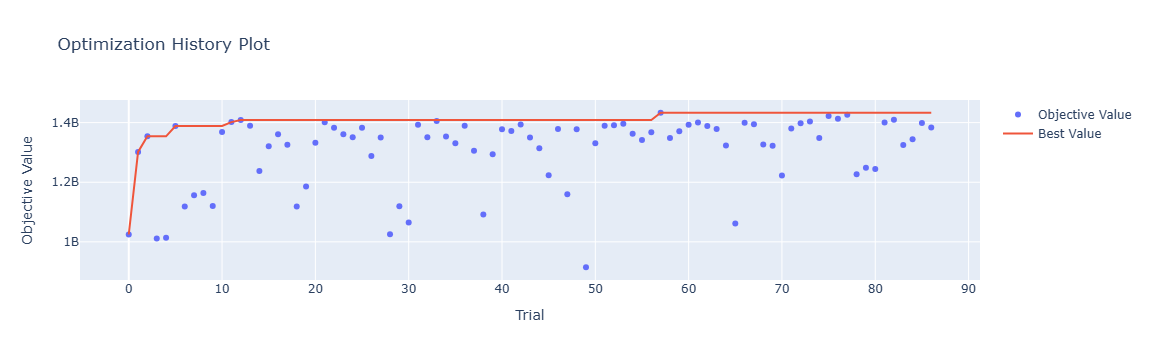

In [13]:
optuna.visualization.plot_optimization_history(study)

In [135]:
# Incluimos febrero y marzo como train

mes_train = (202103)
train_data = data[data['foto_mes'] == mes_train] 
X_train = train_data.drop(['clase_ternaria', 'clase_peso', 'clase_binaria1','clase_binaria2'], axis=1)
y_train_binaria1 = train_data['clase_binaria1']
y_train_binaria2 = train_data['clase_binaria2']
w_train = train_data['clase_peso']


best_iter = study.best_trial.user_attrs["best_iter"]
print(f"Mejor cantidad de árboles para el mejor model {best_iter}")
params = {
    'objective': 'binary',
    'boosting_type': 'gbdt',
    'first_metric_only': True,
    'boost_from_average': True,
    'feature_pre_filter': False,
    'max_bin': 127,
    'num_leaves': study.best_trial.params['num_leaves'],
    'learning_rate': study.best_trial.params['learning_rate'],
    'min_data_in_leaf': study.best_trial.params['min_data_in_leaf'],
    'feature_fraction': study.best_trial.params['feature_fraction'],
    'bagging_fraction': study.best_trial.params['bagging_fraction'],
    'min_gain_to_split': study.best_trial.params['min_gain_to_split'],    
    'seed': 42,
    'verbose': 0,
    'bagging_freq': 1 #añadido 
}

train_data = lgb.Dataset(X_train,
                          label=y_train_binaria2 #cambiar a 1 (no mejora)
                          )

model = lgb.train(params,
                  train_data,
                  num_boost_round=best_iter)


Mejor cantidad de árboles para el mejor model 90
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positiv

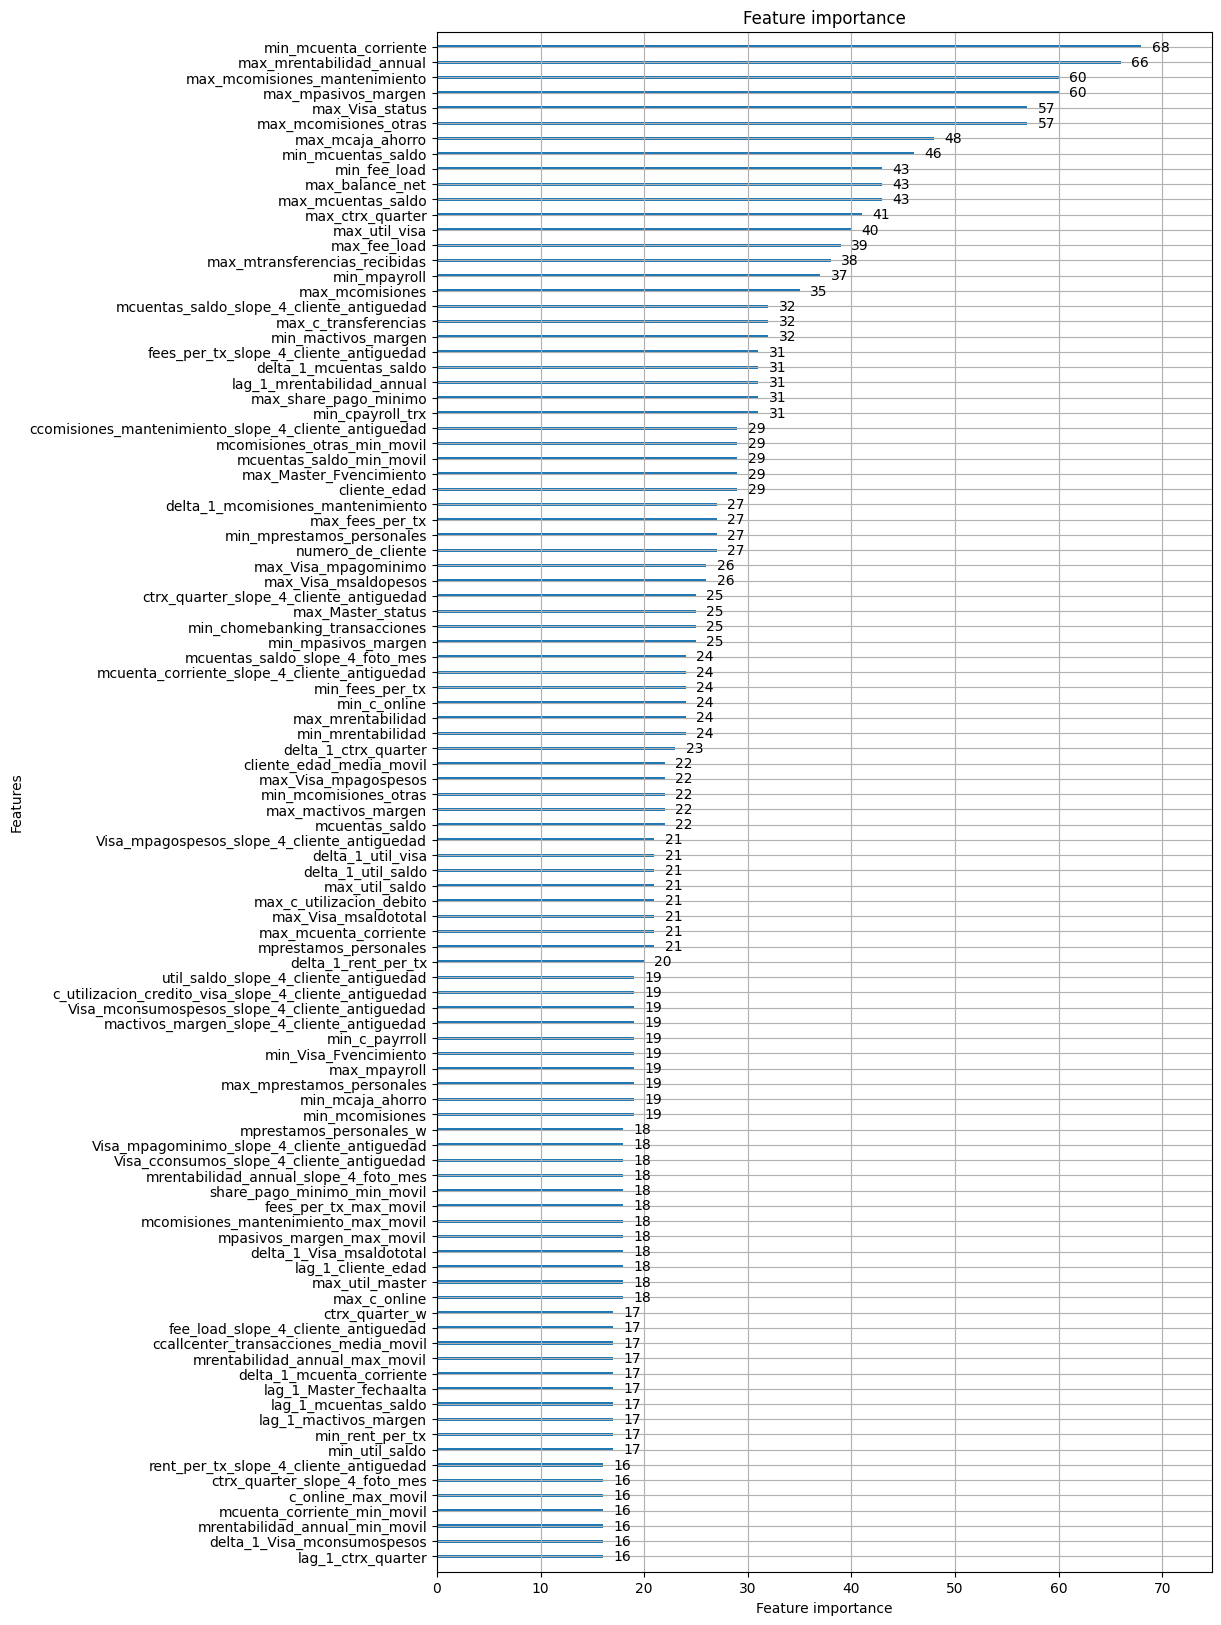

In [18]:
# Feature Importance
lgb.plot_importance(model, figsize=(10, 20), max_num_features=100)
plt.show()

In [19]:
# Guardo
model.save_model(r'modelos/lgb_competencia01_modelo_notebookv3_optimizacion_8_10.txt')

In [ ]:
# model = lgb.Booster(model_file='modelos\lgb_competencia01_prueba_inicial')

In [136]:
# Prediccion
y_pred_lgm = model.predict(X_test)

## Curva de Ganancia

In [137]:
ganancia = np.where(y_test_binaria1 == 1, ganancia_acierto, 0) - np.where(y_test_binaria1 == 0, costo_estimulo, 0)

idx = np.argsort(y_pred_lgm)[::-1]

ganancia = ganancia[idx]
y_pred_lgm = y_pred_lgm[idx]

ganancia_cum = np.cumsum(ganancia)


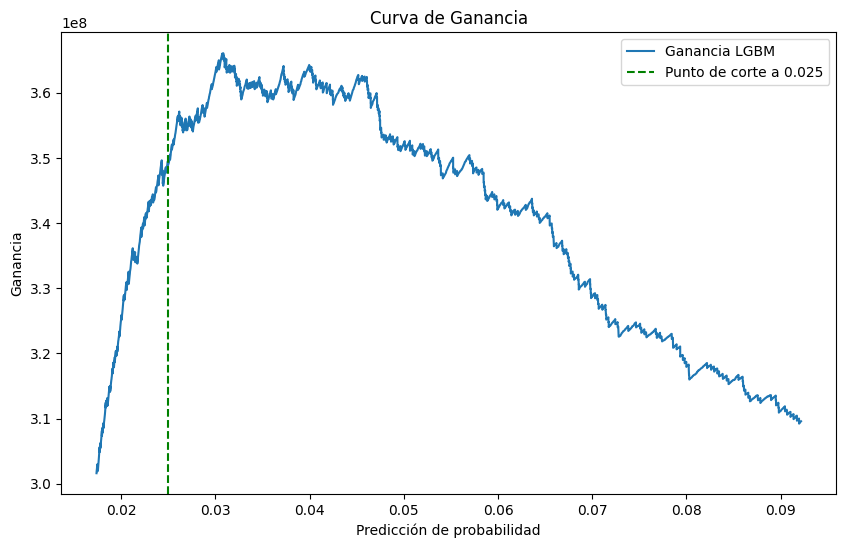

Probabilidad asociada a la ganancia máxima: 0.030830354671165437


In [140]:
piso_envios = 4000
techo_envios = 20000

plt.figure(figsize=(10, 6))
plt.plot(y_pred_lgm[piso_envios:techo_envios], ganancia_cum[piso_envios:techo_envios], label='Ganancia LGBM')
plt.title('Curva de Ganancia')
plt.xlabel('Predicción de probabilidad')
plt.ylabel('Ganancia')
plt.axvline(x=0.025, color='g', linestyle='--', label='Punto de corte a 0.025')
plt.legend()
plt.show()

ganancia_max_idx = np.argmax(ganancia_cum[piso_envios:techo_envios]) + piso_envios
proba_max_ganancia = y_pred_lgm[ganancia_max_idx]
print(f"Probabilidad asociada a la ganancia máxima: {proba_max_ganancia}")

Vaya! realmente nuestro teórico mejor punto de corte no es el que mayor ganancia genera. Es hora de cambiar el enfoque.

En vez de mirar el punto de corte, empezaremos a pensar en cuál es la cantidad máxima de clientes que se deben estimular. Si cambiamos a esto, veremos que el gráfico anterior se ve así

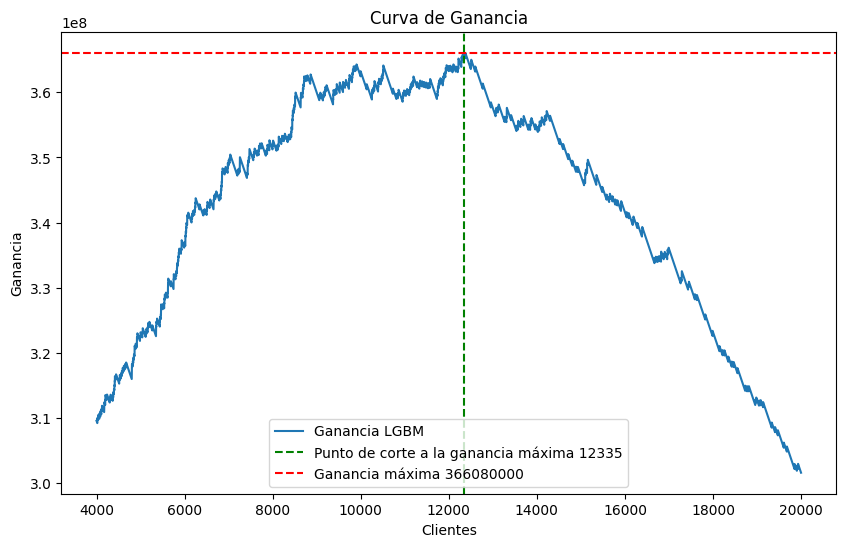

In [141]:
piso_envios = 4000
techo_envios = 20000

ganancia_max = ganancia_cum.max()
gan_max_idx = np.where(ganancia_cum == ganancia_max)[0][0]

plt.figure(figsize=(10, 6))
plt.plot(range(piso_envios, len(ganancia_cum[piso_envios:techo_envios]) + piso_envios), ganancia_cum[piso_envios:techo_envios], label='Ganancia LGBM')
plt.axvline(x=gan_max_idx, color='g', linestyle='--', label=f'Punto de corte a la ganancia máxima {gan_max_idx}')
plt.axhline(y=ganancia_max, color='r', linestyle='--', label=f'Ganancia máxima {ganancia_max}')
plt.title('Curva de Ganancia')
plt.xlabel('Clientes')
plt.ylabel('Ganancia')
plt.legend()
plt.show()


In [128]:
# Prediccion
y_pred_lgm = model.predict(X_test)

In [129]:
# Medicion de ganancia  --hay que volver a correr model.predict para que de bien

def ganancia_prob(y_pred, y_true, prop = 1):
  ganancia = np.where(y_true == 1, ganancia_acierto, 0) - np.where(y_true == 0, costo_estimulo, 0)
  return ganancia[y_pred >= 0.04392701280452514].sum() / prop  #probar con 0.05 en vez de 0.025

print("Ganancia LGBM:", ganancia_prob(y_pred_lgm, y_test_binaria1))

Ganancia LGBM: 333620000.0


## Entrenamiento definitivo incluyendo Abril

In [142]:
#Añadimos abril
mes_train_completo = (202104)
train_data_completo = data[data['foto_mes'] == mes_train_completo] #.isin(mes_train_completo) 
# test_data = data[data['foto_mes'] == mes_test]

X_train_completo = train_data_completo.drop(['clase_ternaria', 'clase_peso', 'clase_binaria1','clase_binaria2'], axis=1)
y_train_completo_binaria1 = train_data_completo['clase_binaria1']
y_train_completo_binaria2 = train_data_completo['clase_binaria2']
w_train_completo = train_data_completo['clase_peso']

# X_test = test_data.drop(['clase_ternaria', 'clase_peso', 'clase_binaria1','clase_binaria2'], axis=1)
# y_test_binaria1 = test_data['clase_binaria1']
# y_test_class = test_data['clase_ternaria']
# w_test = test_data['clase_peso']

In [143]:
#Entrenamiento def


params = {
    'objective': 'binary',
    'boosting_type': 'gbdt',
    'first_metric_only': True,
    'boost_from_average': True,
    'feature_pre_filter': False,
    'max_bin': 127,
    'num_leaves': study.best_trial.params['num_leaves'],
    'learning_rate': study.best_trial.params['learning_rate'],
    'min_data_in_leaf': study.best_trial.params['min_data_in_leaf'],
    'feature_fraction': study.best_trial.params['feature_fraction'],
    'bagging_fraction': study.best_trial.params['bagging_fraction'],
    'min_gain_to_split': study.best_trial.params['min_gain_to_split'],    
    'seed': 42,
    'verbose': 0,
    'bagging_freq': 1

}

train_data_completo = lgb.Dataset(X_train_completo,
                          label=y_train_completo_binaria2
                          ) #weight=w_train_completo

model_completo = lgb.train(params,
                  train_data_completo,
                  num_boost_round=best_iter)


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

## Exportación

In [146]:
# Generar predicciones para junio 2021 y exportar a CSV

# 1. Filtrar datos de junio
X_junio = data[data['foto_mes'] == 202106].copy()
clientes_junio = X_junio['numero_de_cliente']
X_junio = X_junio.drop(columns=['clase_ternaria', 'clase_peso', 'clase_binaria1', 'clase_binaria2'], errors='ignore')



# 2. Predecir probabilidades para BAJA+2
proba = model_completo.predict(X_junio)

# Seleccionar los N clientes con mayor probabilidad
sorted_indices = np.argsort(proba)[::-1]
n_clientes = 13000  # Ajustar basado en el análisis de ganancia óptima
predicted = np.zeros_like(proba, dtype=int)
predicted[sorted_indices[:n_clientes]] = 1




# 3. Exportar a CSV
df_submit = pd.DataFrame({
    'numero_de_cliente': clientes_junio,
    'Predicted': predicted
})
df_submit.to_csv('prediccion_08_10_nbv3_11.csv', index=False)
print("Archivo prediccion_junio.csv generado.")

Archivo prediccion_junio.csv generado.
